**Аналитик: khmelkoff**

# Анализ увольнений: проверка гипотез
### Анализ факторов, связанных с увольнениями по собственному желанию
*(сокращенная редакция)*

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn
from itertools import combinations
from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.stats.weightstats import zconfint

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [66]:
data = pd.read_csv('data/HR_data3.csv', sep=';', decimal=',')
data.head()

,Income,Tenure,Age,Degree,IncomeChanges,IncomeRaise,Gender,Travels,Trainings,ofProjects,Vacations,WorkTime,Marital,Resigned
0,0.381943,21,26,Senior,0,0.000000,M,0,0,2,104.0,7.111111,Single,1
1,0.331059,133,51,Senior,1,0.156927,F,0,0,2,80.0,7.428571,Married,0
2,0.377046,55,31,Senior,1,0.109244,M,0,0,3,96.0,7.301587,0,0
3,0.639836,27,23,Regular,2,3.072727,M,0,3,2,80.0,6.367347,Single,0
4,0.429605,26,46,Senior,0,0.000000,M,11,8,2,40.0,5.079365,Married,0


In [4]:
data.shape

(429, 14)

In [5]:
data.Resigned.value_counts()

0    306
1    123
Name: Resigned, dtype: int64

#### Признаки

- Income - Доход сотрудников, нормированный неизвестным для аналитика способом
- Tenure - Стаж в компании в месяцах
- Age - Возраст (полных лет)
- Degree - Уровень сотрудника (Senior, Regular, Junior)
- IncomeChanges - Изменение дохода за последние три года (0 - нет, 1 раз, 2 раза, 3 раза)
- IncomeRaise - Изменение дохода за последний год в процентах
- Gender - пол
- Travels - Кол-во командировок в днях за последний год
- Trainings - Кол-во часов тренингов за последний год
- ofProjects - Текущее кол-во проектов у сотрудника
- Vacations - Кол-во отпускных часов за последний год
- WorkTime - Среднее рабочее время в день
- Marital - Семейный статус
- Resigned - Целевой признак, увольнение по собственному желанию = 1 (уволенные по инициативе компании исключены из набора данных)

## 1. Среднее рабочее время

В двух группах, уволившихся сотрудников (Resigned==1) и тех, кто продолжает работать (Resigned = 0) проверим гипотезы: 
- о равенстве медианных значений среднего рабочего времени с помощью подходящей интервальной оценки 
- о равенстве распределений с помощью одного из подходящих непараметрических критериев

Оценим значимость полученных результатов с практической точки зрения

Проверка сбалансированности выборки по параметру Resigned

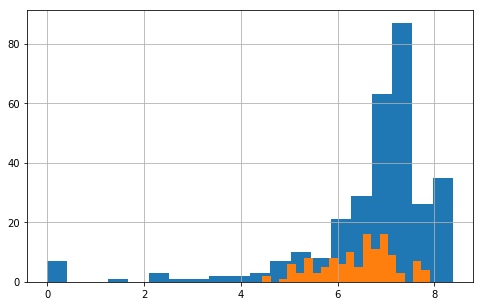

In [6]:
data.WorkTime[data.Resigned==0].hist(figsize=(8,5), bins=20)
data.WorkTime[data.Resigned==1].hist(figsize=(8,5), bins=20)

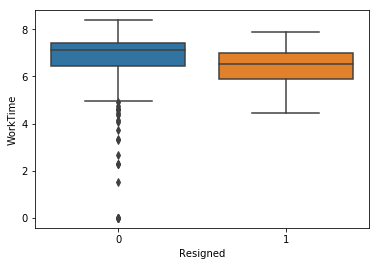

In [7]:
ax = seaborn.boxplot(x="Resigned", y="WorkTime", data=data)

По графикам можно заключить следующее: Оба распределения скошенные, несимметричные, максимум справа. Работающих сотрудников существенно больше (дисбалланс классов). Медианные значения различаются.

### Проверка гипотезы о равенстве медианных значений среднего рабочего времени с помощью интервальной оценки:

$H_0\colon med_0 = med_1$

$H_1\colon med_0 \neq med_1$,

где $med_0$ - медиана среднего рабочего времени для работающих сотрудников, $med_1$ - для уволившихся (Resigned=1)

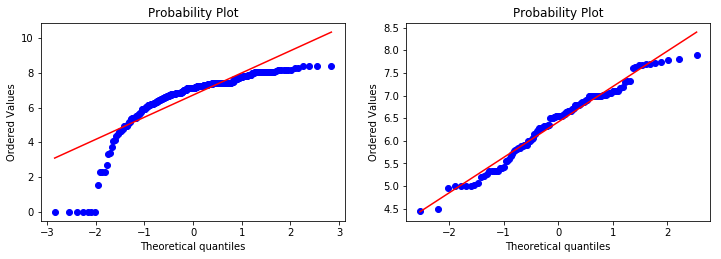

In [8]:
# QQ-plot
pylab.figure(figsize=(12,8))
pylab.subplot(2,2,1)
stats.probplot(data.WorkTime[data.Resigned==0], dist="norm", plot=pylab)
pylab.subplot(2,2,2)
stats.probplot(data.WorkTime[data.Resigned==1], dist="norm", plot=pylab)
pylab.show()

Очевидно, что распределения различны и, как минимум, выборка для работающих сотрудников взята не из нормального распределения, поэтому для построения интервальных оценок попробуем использовать бутстреп

In [9]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [10]:
get_bootstrap_samples(data.WorkTime[data.Resigned==0].values, 1000).shape

(1000, 306)

In [11]:
np.random.seed(0)
median_scores_0 = list(map(lambda x: np.median(x), 
                      get_bootstrap_samples(data.WorkTime[data.Resigned==0].values, 1000)))
median_scores_1 = list(map(lambda x: np.median(x),  
                      get_bootstrap_samples(data.WorkTime[data.Resigned==1].values, 1000)))

print("95% confidence interval for the WorkTime median:", 
    stat_intervals(median_scores_0, 0.05))
print("95% confidence interval for the WorkTime median Resigned:", 
    stat_intervals(median_scores_1, 0.05))

95% confidence interval for the WorkTime median: [7.04761905 7.23809524]
95% confidence interval for the WorkTime median Resigned: [6.331454   6.66666667]


#### Точечная оценка разности медиан (наблюдаемая)

In [12]:
med_delta_observed = np.median(data.WorkTime[data.Resigned==0])-np.median(data.WorkTime[data.Resigned==1])
print("difference between medians:", med_delta_observed)

difference between medians: 0.5714285710000002


#### Интервальная оценка разности медиан

In [13]:
delta_median_scores = list(map(lambda x: x[0] - x[1], zip(median_scores_0, median_scores_1)))

In [14]:
print("95% confidence interval for the difference between medians", 
stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [0.44444444 0.78966111]


#### Оценка достигамого уровня значимости

In [15]:
np.mean(np.array(delta_median_scores)<=0)

0.0

In [16]:
min(np.array(delta_median_scores))

0.317460317000001

- **Вывод 1.1:** 95% доверительный интервал для разности медиан не содержит 0 (а доверительные интервалы для выборочных медиан не перекрываются), следовательно нулевая гипотеза о равенстве медиан среднего рабочего времени для работающих и уволившихся сотрудников на уровне значимости 0.05 **отвергается**. Минимальное значение разности медиан для бутсреп выборок составляет 0.32 часа. Оценка достигаемого уровня значимости равна нулю - нет ни одного кейса, в котором медианные значения совпали.

### Проверка гипотезы о равенстве распределений (WorkTime)

$H_0\colon F_{X_0}(x) = F_{X_1}(x+\Delta), \Delta = 0$

$H_1\colon F_{X_0}(x) = F_{X_1}(x+\Delta), \Delta \neq 0$,

где F - соответствующие распределения, $X_0$ - выборка для работающих сотрудников, $X_1$ - для уволившихся

Используем перестановочный критерий для независимых выборок:

In [17]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test_ind(sample1, sample2, max_combinations = None, 
                         alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample1, sample2)
    
    zero_distr = permutation_zero_dist_ind(sample1, sample2, max_combinations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. 
                    for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [18]:
sample1 = data.WorkTime[data.Resigned==1]
sample0 = data.WorkTime[data.Resigned==0]
print(sample1.shape, sample0.shape)

(123,) (306,)


In [19]:
np.random.seed(0)
print("Достигаемый уровень значимости: p-value %f" % 
    permutation_test_ind(sample0, sample1, max_combinations = 10000))

Достигаемый уровень значимости: p-value 0.030500


- **Вывод 1.2:** Нулевая гипотеза о равенстве распределений среднего рабочего времени для работающих и уволившихся сотрудников против альтернативы о неравенстве ($\Delta \neq 0$) на уровне значимости 0.05 **отвергается**. Достигаемый уровень значимости: p-value 0.0305

- **Размер эффекта:** Минимальное значение разности медиан для бутстреп выборок составляет 0.32 часа (19 минут), точечная оценка разности медиан - 0.57 часа (34 минуты). Можно предположить значимость полученных результатов с практической точки зрения.

## 2. Доход сотрудника

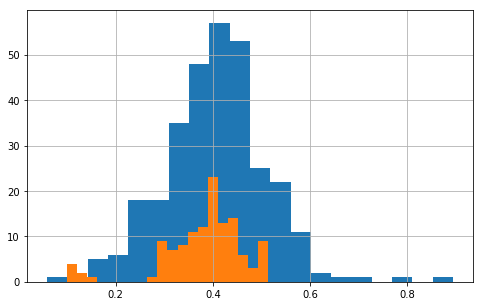

In [20]:
data.Income[data.Resigned==0].hist(figsize=(8,5), bins=20)
data.Income[data.Resigned==1].hist(figsize=(8,5), bins=20)

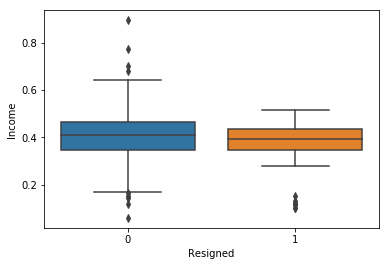

In [21]:
ax = seaborn.boxplot(x="Resigned", y="Income", data=data)

По графикам можно заключить следующее: Распределения похожи, медианы незначительно различаются, распрежделение для работающих сотрудников шире и имеет более длинные хвосты.

In [22]:
income0 = data.Income[data.Resigned==0]
income1 = data.Income[data.Resigned==1]

In [24]:
print('95%% confidence interval for the Income mean: [%f, %f]' % zconfint(income0))

95% confidence interval for the Income mean: [0.394382, 0.418020]


In [23]:
print('95%% confidence interval for the Income mean: [%f, %f]' % zconfint(income1))

95% confidence interval for the Income mean: [0.365386, 0.395684]


In [25]:
income0.value_counts().head()

0.388472    9
0.428462    9
0.462454    8
0.442744    8
0.354195    7
Name: Income, dtype: int64

In [26]:
income1.value_counts().head()

0.382759    3
0.358956    3
0.399897    2
0.451313    2
0.416464    2
Name: Income, dtype: int64

В выборка присутствуют повторяющиеся значения, следовательно нельзя использовать ранговый критерий. Воспользуемся перестановочным тестом.

### Проверка гипотезы о равенстве распределений (Income)

$H_0\colon F_{X_0}(x) = F_{X_1}(x+\Delta), \Delta = 0$

$H_1\colon F_{X_0}(x) = F_{X_1}(x+\Delta), \Delta \neq 0$,

где F - соответствующие распределения, $X_0$ - выборка для работающих сотрудников, $X_1$ - для уволившихся

In [27]:
print("p-value: %f" % permutation_test_ind(income0, income1, max_combinations = 10000))

p-value: 0.018400


- **Вывод 2.1:** Нулевая гипотеза о равенстве распределений дохода для работающих и уволившихся сотрудников против альтернативы о неравенстве ($\Delta \neq 0$) на уровне значимости 0.05 **отвергается**. Достигаемый уровень значимости: p-value 0.018.
- **Вывод 2.2:** Есть незначительное перекрытие 95% доверительных интервалов для средних значений дохода в двух группах сотрудников. Не представляется возможным оценить размер эффекта, т.к. доход нормирован.

## 3. Изменение дохода (IncomeChanges)

In [28]:
data.IncomeChanges.value_counts()

0    226
1    165
2     33
3      5
Name: IncomeChanges, dtype: int64

Проверим гипотезу о том, что увольнение сотрудников связано с изменением дохода. Используем несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия). Будем рассматривать два класса - изменения дохода не было (IncomeChanges==0) и изменение дохода было (IncomeChanges>0).

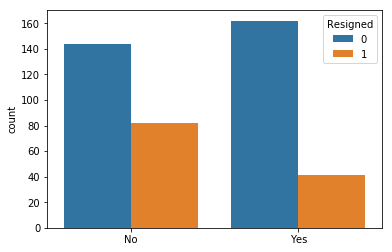

In [29]:
seaborn.countplot(x=['Yes' if x > 0 else 'No' for x in data.IncomeChanges], 
                  hue=data.Resigned)

По графику можно сделать заключение, что доля уволившихся сотрудников выше среди тех у кого не было изменений в доходе.

### Проверка гипотезы о том, что увольнение сотрудников связано с изменением дохода (при помощи доверительного интервала)

$H_0\colon p_1 - p_2 = 0$

$H_1\colon p_1 - p_2 \neq 0$,

где $p_1$ - доля уволившихся среди сотрудников с изменением дохода, $p_2$ - доля уволившихся среди сотрудников без изменения дохода

#### Точечная оценка разности долей

In [30]:
sample1 = data.Resigned[data.IncomeChanges>0] # изменение было
sample2 = data.Resigned[data.IncomeChanges==0] # доход не менялся

In [31]:
p1 = float(sum(sample1)) / len(sample1)
p2 = float(sum(sample2)) / len(sample2)
print('доля уволившихся с изменением: %f, доля уволившихся без изменения: %f, p1 - p2: %f' % (p1, p2, p1-p2))

доля уволившихся с изменением: 0.201970, доля уволившихся без изменения: 0.362832, p1 - p2: -0.160861


In [32]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) 
                                            + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1)
                                             + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))


def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

In [35]:
proportions_diff_confint = proportions_diff_confint_ind(sample1, sample2, alpha = 0.05)
print("95%% confidence interval for a difference between proportions: [%f, %f]" % 
    proportions_diff_confint)

95% confidence interval for a difference between proportions: [-0.244406, -0.077317]


In [37]:
print("p-value 'two side':", 
    proportions_diff_z_test(proportions_diff_z_stat_ind(sample1, sample2)))

p-value 'two side': 0.00023461950611758375


- **Вывод 3.1:** 95% доверительный интервал для разности долей уволившихся среди сотрудников с изменением дохожа и тех, у кого доход не менялся не содержит 0, нулевая гипотеза о равенстве долей на уровне значимости 0.05 **отвергается**, достигаемый уровень значимости ~ 0.0002.

### Проверка гипотезы о том, что увольнение сотрудников связано с изменением дохода (при помощи критерия независимости хи-квадрат)

$H_0\colon$ увольнение и изменение дохода независимы 

$H_1\colon$ увольнение и изменение дохода зависимы

In [38]:
tab = pd.crosstab(data.Resigned, data.IncomeChanges>0)
tab

IncomeChanges,False,True
Resigned,,
0,144,162
1,82,41


Проверим гипотезу о независимости (без поправки Йется, наблюдений достаточно)

In [39]:
chi2, p, L, expected = stats.chi2_contingency(tab, correction=False)
print("статистика: ", chi2, "p-value: ", p)

статистика:  13.531283737175062 p-value:  0.0002346195061175181


- **Вывод 3.2:** Нулевая гипотеза о независимости увольнений от изменения дохода на уровне значимости 0.05 **отвергается**, достигаемый уровень значимости ~ 0.00023.

## 4. Уровень сотрудника

In [40]:
data.Degree.value_counts()

Senior     342
Regular     71
Junior      16
Name: Degree, dtype: int64

Проверим гипотезу о том, что уровень сотрудника связан с принятием решения об увольнении. Составим таблицу сопряженности "уровень сотрудника" на "увольнение", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек.

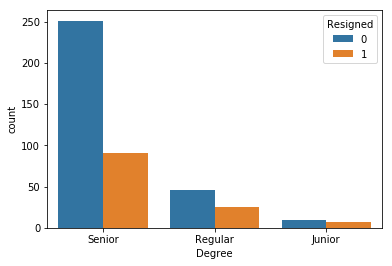

In [41]:
seaborn.countplot(x=data.Degree, hue=data.Resigned)

По графику можно заключить следующее: наиболее многочисленной группой среди уволившихся сотрудников являются старшие сотрудники, наименее многочисленнной - молодые. По графику оценить отличия долей для разных групп возможным не представлется.

In [42]:
deg_levels = ['Junior', 'Regular', 'Senior']

### Проверка гипотезы о том, что уровень сотрудника не связан с увольнеием

$H_0\colon$ увольнения и уровень сотрудника независимы 

$H_1\colon$ увольнения и уровень сотрудника зависимы

In [43]:
tab = pd.crosstab(data.Resigned, data.Degree)
tab.columns = deg_levels
tab

,Junior,Regular,Senior
Resigned,,,
0,9,46,251
1,7,25,91


In [44]:
levels = range(3)
deg_pairs = list(combinations(levels,2))
print(deg_pairs)

[(0, 1), (0, 2), (1, 2)]


Для проверки гипотезы используем точный тест Фишера на каждой паре сочетаний уровней.

In [46]:
for pair in deg_pairs:
    subtable = tab.iloc[:, list(pair)]
    print(pair, (subtable.iloc[0,0]+subtable.iloc[1,0])
        *(subtable.iloc[1,0]+subtable.iloc[1,1])/float(np.sum(np.array(subtable))))

(0, 1) 5.885057471264368
(0, 2) 4.379888268156424
(1, 2) 19.941888619854723


In [47]:
fisher = []
for pair in deg_pairs:
    subtable = tab.iloc[:,list(pair)]
    pair_named = deg_levels[pair[0]] +' vs. '+deg_levels[pair[1]] 
    fisher.append([pair_named, stats.fisher_exact(subtable)[0], stats.fisher_exact(subtable)[1]])
fisher = pd.DataFrame(fisher, columns=['pair','odds','p_value'])

In [48]:
fisher

,pair,odds,p_value
0,Junior vs. Regular,0.698758,0.572816
1,Junior vs. Senior,0.466135,0.153211
2,Regular vs. Senior,0.667092,0.148736


Сделаем поправку на множественную проверку гипотез по методу Холма:

In [49]:
reject, p_corrected, a1, a2 = multipletests(fisher.p_value, 
                                            alpha = 0.05, 
                                            method = 'holm') 
fisher['p_corrected']=p_corrected
fisher['reject']=reject
fisher

,pair,odds,p_value,p_corrected,reject
0,Junior vs. Regular,0.698758,0.572816,0.572816,False
1,Junior vs. Senior,0.466135,0.153211,0.446208,False
2,Regular vs. Senior,0.667092,0.148736,0.446208,False


- **Вывод 3.1:** С учетом поправки на множественную проверку гипотез (и без), нулевая гипотеза об отсутствии взаимосвзи между уровнем сотрудника и увольнен6ием на уровне занчимости 0.05 отвергается для всех пар сочетаний (Junior vs. Regular, Junior vs. Senior, Regular vs. Senior).

## 5. Корпоративное обучение (Тренинги)

Проверим, как связано прохождение корпоративного обучения с индикатором увольнения: предложим меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

In [51]:
np.sum(data.Trainings>0)

135

In [52]:
index = (data.Trainings>0)
data.loc[index,'Trainings_bin']=1
data.loc[-index,'Trainings_bin']=0

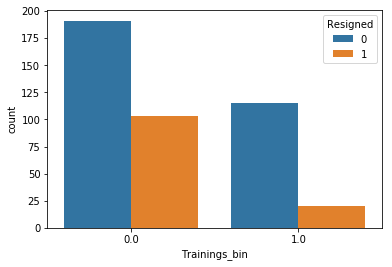

In [53]:
seaborn.countplot(x=data.Trainings_bin, hue=data.Resigned)

1 - сотрудник проходил обучение в течение года, 0 - сотрудник не проходил обучение в течение года

На основании графика можно сделать предположение о наличии связи между фактом прохождения корпоративного обучения и индикатором увольнения. Доля уволившихся сотрудников среди тех, кто не участвовал в корпоративном обучении - выше.

In [54]:
tab = pd.crosstab(data.Resigned, data.Trainings_bin)
tab

Trainings_bin,0.0,1.0
Resigned,,
0,191,115
1,103,20


### Проверим гипотезу о независимости увольнений и корпоративного обучения

$H_0\colon$ увольнения и прохождение корпоративного обучения независимы 

$H_1\colon$ увольнения и прохождение корпоративного обучения зависимы

In [55]:
chi2, p, L, expected = stats.chi2_contingency(tab, correction=False)
print("статистика: ", chi2, "p-value: ", p)

статистика:  18.494378329470905 p-value:  1.704061901818922e-05


### Оценка силы взаимосвязи с помощью корреляции Мэтьюса

$H_0\colon MCC_{X_1X_2} = 0$

$H_1\colon MCC_{X_1X_2} \neq 0$,

где $X_1$ - бинарная переменная корпоративного обучения, а $X_2$ - бинарный индикатор увольнения

In [56]:
a = tab.iloc[0,0]
b = tab.iloc[0,1]
c = tab.iloc[1,0]
d = tab.iloc[1,1]
MCC = (a*d-b*c)/(np.sqrt((a+b)*(a+c)*(b+d)*(c+d)))
print('Коэффициент корреляции Мэтьюса: ',MCC)
print('Достигаемый уровень значимости: ',p)

Коэффициент корреляции Мэтьюса:  -0.20763053483636665
Достигаемый уровень значимости:  1.704061901818922e-05


- **Вывод 5.1:** Гипотеза о независимости для пары "отсутствие/наличие обучения" и увольнениями **отвергается**, достигаемый уровень значимости ~ 1.7e-5.
- **Вывод 5.2:** На уровне значимости 0.05 гипотеза о равенстве нулю коэффициента корреляции Мэтьюса для бинарной переменной (отсутствие обучения-0, обучение-1) и индикатором увольнения **отвергается**, достигаемый уровень значимости ~ 1.7e-5
- **Вывод 5.3:** Обнаружена слабая отрицательная взаимосвязь между прохождением корпоративного обучения и увольнением.

## 6. Возраст

Относительно двух групп сотрудников проверим следующие гипотезы: 
- a) о равенстве средних значений возрастов работающих и уволившихся сотрудников 
- b) о равенстве распределений с помощью одного из подходящих непараметрических критериев

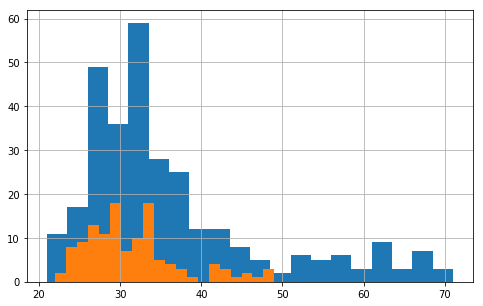

In [57]:
data.Age[data.Resigned==0].hist(figsize=(8,5), bins=20)
data.Age[data.Resigned==1].hist(figsize=(8,5), bins=20)

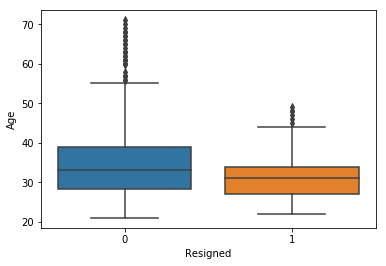

In [58]:
ax = seaborn.boxplot(x="Resigned", y="Age", data=data)

По графикам можно заключить что медианные значения возрастов в двух группах различаются. Группа работающих сотрудников имеет более длинный хвост. Оба распределения несимметричны, максимум смещен влево (младшие возраста).

### Проверка гипотезы о равенстве средних значений возраста с помощью интервальной оценки:

$H_0\colon mean_0 = mean_1$

$H_1\colon mean_0 \neq mean_1$,

где $mean_0$ - среднее значение возраста для работающих сотрудников, $mean_1$ - для уволившихся (Resigned=1)

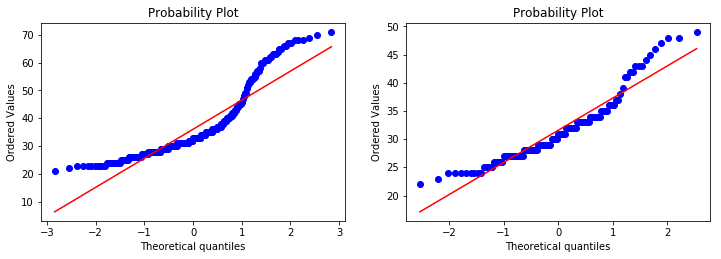

In [59]:
# QQ-plot
pylab.figure(figsize=(12,8))
pylab.subplot(2,2,1)
stats.probplot(data.Age[data.Resigned==0], dist="norm", plot=pylab)
pylab.subplot(2,2,2)
stats.probplot(data.Age[data.Resigned==1], dist="norm", plot=pylab)
pylab.show()

Выборки взяты не из нормального распределения, поэтому для построения итнтервальных оценок будем использовать бутстреп

In [60]:
np.random.seed(0)
mean_scores_0 = list(map(lambda x: np.mean(x), 
                      get_bootstrap_samples(data.Age[data.Resigned==0].values, 1000)))
mean_scores_1 = list(map(lambda x: np.mean(x),  
                      get_bootstrap_samples(data.Age[data.Resigned==1].values, 1000)))

print("95% confidence interval for the Age mean:", 
    stat_intervals(mean_scores_0, 0.05))
print("95% confidence interval for the Age mean Resigned:", 
    stat_intervals(mean_scores_1, 0.05))

95% confidence interval for the Age mean: [34.79248366 37.27794118]
95% confidence interval for the Age mean Resigned: [30.56097561 32.62601626]


#### Точечная оценка разности средних (наблюдаемая)

In [61]:
mean_delta_observed = np.mean(data.Age[data.Resigned==0])- np.mean(data.Age[data.Resigned==1])
print("difference between means:", mean_delta_observed)

difference between means: 4.460385780328394


#### Интервальная оценка разности средних

In [62]:
delta_mean_scores = list(map(lambda x: x[0] - x[1], zip(mean_scores_0, mean_scores_1)))
print("95% confidence interval for the difference between means", 
    stat_intervals(delta_mean_scores, 0.05))

95% confidence interval for the difference between means [2.87803284 6.09477523]


Минимальное значение

In [63]:
np.min(delta_median_scores)

0.317460317000001

- **Вывод 6.1:** 95% доверительные интервалы для средних значений возрастов работающих и уволившихся сотрудников не пересекаются, нулевая гипотеза о равенстве средних значений возраста **отвергается**.

### Проверка гипотезы о равенстве распределений возрастов в двух группах

$H_0\colon F_{X_0}(x) = F_{X_1}(x+\Delta), \Delta = 0$

$H_1\colon F_{X_0}(x) = F_{X_1}(x+\Delta), \Delta \neq 0$,

где F - соответствующие распределения, $X_0$ - выборка значений возрастов для работающихсотрудников, $X_1$ - для уволившихся

Используем перестановочный критерий для независимых выборок:

In [64]:
sample1 = data.Age[data.Resigned==1].values
sample0 = data.Age[data.Resigned==0].values
print(sample1.shape, sample0.shape)

(123,) (306,)


In [65]:
np.random.seed(0)
print("Достигаемый уровень значимости: p-value %f" % 
    permutation_test_ind(sample0, sample1, max_combinations = 10000))

Достигаемый уровень значимости: p-value 0.000100


- **Вывод 6.2:** Нулевая гипотеза о равенстве распределений значений возрастов для работающих и уволившихся сотрудников против альтернативы о неравенстве распределений ($\Delta \neq 0$) на уровне значимости 0.05 **отвергается**. Достигаемый уровень значимости: p-value 0.0001.